# Image classification using CNN

Data url: https://www.kaggle.com/code/chitwanmanchanda/vegetable-image-classification-using-cnn/data

In [3]:
# Set data directories here

train_dir=("./Vegetable Images/train")
valid_dir=("./Vegetable Images/validation")
test_dir=("./Vegetable Images/test")

splits = [train_dir, valid_dir, test_dir]

In [1]:
# Torch functions
import torch
from torchvision.io import read_image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from accelerate import Accelerator
from transformers import get_scheduler

# Other utilities
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Prior Data Exploration

We first should check what kinds of classes there are and images per class

In [47]:
# Check number of classes per data split
for split in splits:
    name = os.path.basename(split)
    print(f"{name}: {len(os.listdir(split))} classes")

train: 15 classes
validation: 15 classes
test: 15 classes


The bottom function will remove hidden files that may be created by the system when accessing the folders on MacOS (e.g: .DS_Store)

In [48]:
def remove_hidden_files(root_directory):
    # Traverse the directory tree
    for root, dirs, files in os.walk(root_directory):
        for name in files:
            # Identify hidden files (in Unix-like systems, hidden files start with a '.')
            if name.startswith('.') or name in {'Thumbs.db'}:
                full_path = os.path.join(root, name)
                print(f'Removing file: {full_path}')
                os.remove(full_path)
        
        for name in dirs:
            # Identify hidden directories
            if name.startswith('.'):
                full_path = os.path.join(root, name)
                print(f'Removing directory: {full_path}')
                os.rmdir(full_path)


# For data integrity purposes (Uncomment below lines to remove all hidden files inside the data folder)

# remove_hidden_files(os.path.dirname(train_dir))


In [49]:
for split in splits:
    
    name = os.path.basename(split)
    total = 0
    for folder in os.listdir(split):
        num_files = len(os.listdir(os.path.join(split, folder)))
        total += num_files
        print(f"{folder}: {num_files}")
    print(20*'-')    
    print(f"Total: {total}")
    print(20*'-') 
    print()

Bean: 1000
Bitter_Gourd: 1000
Bottle_Gourd: 1000
Brinjal: 1000
Broccoli: 1000
Cabbage: 1000
Capsicum: 1000
Carrot: 1000
Cauliflower: 1000
Cucumber: 1000
Papaya: 1000
Potato: 1000
Pumpkin: 1000
Radish: 1000
Tomato: 1000
--------------------
Total: 15000
--------------------

Bean: 200
Bitter_Gourd: 200
Bottle_Gourd: 200
Brinjal: 200
Broccoli: 200
Cabbage: 200
Capsicum: 200
Carrot: 200
Cauliflower: 200
Cucumber: 200
Papaya: 200
Potato: 200
Pumpkin: 200
Radish: 200
Tomato: 200
--------------------
Total: 3000
--------------------

Bean: 200
Bitter_Gourd: 200
Bottle_Gourd: 200
Brinjal: 200
Broccoli: 200
Cabbage: 200
Capsicum: 200
Carrot: 200
Cauliflower: 200
Cucumber: 200
Papaya: 200
Potato: 200
Pumpkin: 200
Radish: 200
Tomato: 200
--------------------
Total: 3000
--------------------



In [50]:
sample = read_image(os.path.join(test_dir, 'Capsicum', '1076.jpg'))
dims = sample.permute(1,2,0).shape
orig_height, orig_width, channels = dims

print(f"Original image size: {orig_height}x{orig_width} with {channels} channels")


Original image size: 224x224 with 3 channels


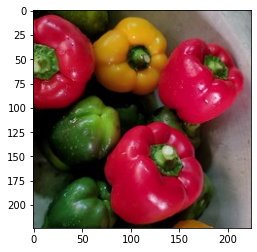

In [51]:
plt.imshow(sample.permute(1,2,0))

In [53]:
def image_transform(image_path, new_width, new_height):
    
    image = read_image(image_path) / 255.0 # Normalize image
    resize = transforms.Resize((new_height, new_width)) # Resize to new shape
    return resize(image)


# Loading the Data

In [54]:
class VegetableData(torch.utils.data.Dataset):
    def __init__(self, split_dir, new_width = orig_height, new_height = orig_width):
        self.data = []
        self.label = []
        
        classes = os.listdir(split_dir)
        self.label_map = dict(zip(classes, range(len(classes))))
        
        self.split_name = os.path.basename(split_dir)

        with tqdm(total=len(classes), desc=f"Loading from {self.split_name}", unit="class") as class_pbar:
            for i, (root, subdir, files) in enumerate(os.walk(split_dir)):
                if i == 0:
                    continue
                    
                if root[root.rindex('/')+1:] in {'.DS_Store', '.ipynb_checkpoints'}:
                    continue
                    
                for file in files:
                    if file.endswith('.jpg'):
                        label = os.path.basename(root)
                        img_path = os.path.join(root, file)
                        tensor = image_transform(img_path, new_width, new_height)
                        self.data.append(tensor)
                        self.label.append(self.label_map[label])
                class_pbar.update(1)
                    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        out = {}
        out['data'] = self.data[idx]
        out['label'] = self.label[idx]
        return out
  

In [55]:
target_size = (150, 150)
train_data = VegetableData(train_dir, *target_size)
validation_data = VegetableData(valid_dir, *target_size)
test_data = VegetableData(test_dir, *target_size)

Loading from test: 100%|██████████| 15/15 [00:10<00:00,  1.42class/s]


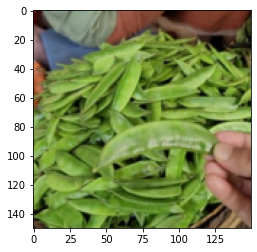

In [56]:
plt.imshow(test_data[1]['data'].permute(1, 2, 0)) # Check to make sure image loaded correctly

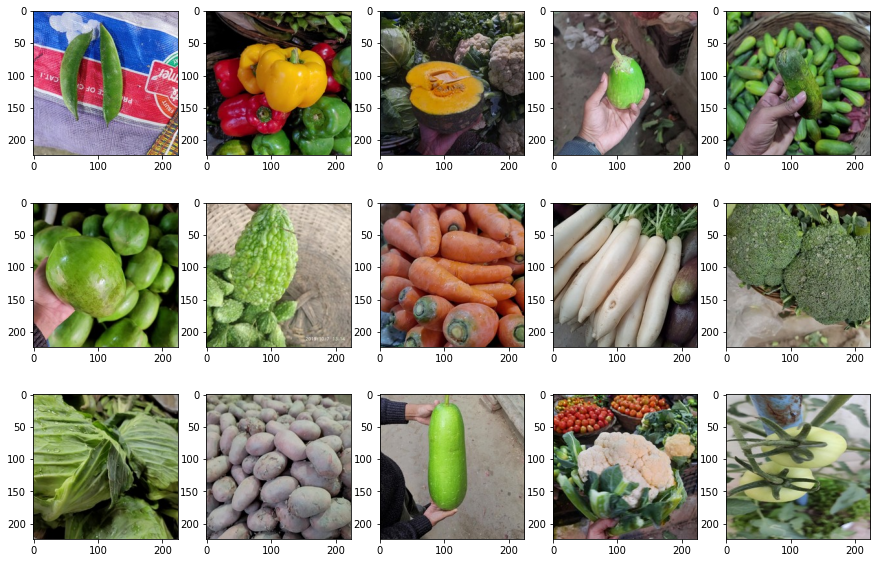

In [57]:
fig, ax = plt.subplots(3, 5, figsize=(15, 10))

j = 0
for i, vegetable in enumerate(os.listdir(valid_dir)):
    img_path = os.path.join(valid_dir, vegetable)
    sample_img = os.listdir(img_path)[0]
    model_image = read_image(os.path.join(img_path,sample_img))
    ax[i % 3][j % 5].imshow(model_image.permute(1, 2, 0))
    ax[i % 3][j % 5].grid(False)
    j += 1
plt.show()

# Building the Model

We are going to build a CNN model with the following:
* Convolution layer with 32 filters of size 3x3, strides of 1, same padding and relu activation function, specify the input_shape
* MaxPooling layer with a pool size of 2
* Convolution layer with 64 filters of size 3x3, strides of 1, same padding and relu activation function
* MaxPooling layer with a pool size of 2
* Flatten layer to flatten the 3 dimensional feature volume
* Dense layer (Fully-connected) with 128 neurons and relu activation function
* Dropout layer with a dropout rate of 25%
* Dense layer (Fully-connected) with 128 neurons and relu activation function
* Final output layer with neuron number the same as class number of the dataset, and softmax activation function


In [58]:
class CNNModel(torch.nn.Module):
    def __init__(self, input_shape = dims[:2], input_channels = 3, dropout = 0.25):
        
        input_shape = np.array(input_shape)
        super().__init__()
        
        c1, c2 = 32, 64                 # Number of filters in both conv layers
        k = (3, 3)                      # Kernel size
        p = (2, 2)                      # Pooling size


        self.conv1 = torch.nn.Conv2d(input_channels, c1, kernel_size = k, stride=1, padding = 'same')
        self.maxPool = torch.nn.MaxPool2d(kernel_size = p)
        self.conv2 = torch.nn.Conv2d(c1, c2, kernel_size = k, stride=1, padding = 'same')
        
        input_shape //= p[0]**2;
        pool_out_dim = np.array([*input_shape, c2])
        flattened_dim = np.prod(pool_out_dim)
        l1, l2, n_classes = 128, 128, 15
        
        self.dense1 = torch.nn.Linear(flattened_dim, l1)
        self.dropout = torch.nn.Dropout(dropout)
        self.dense2 = torch.nn.Linear(l1, l2)
        self.dense3 = torch.nn.Linear(l2, n_classes)
        
         
    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x)) # 1st Conv layer has relu activation
        x = self.maxPool(x)
        x = torch.nn.functional.relu(self.conv2(x)) # 2nd Conv layer has relu activation
        x = self.maxPool(x)
        x = torch.flatten(x, start_dim = 1) # Flatten layer flattens on everything but batch dimension
        x = torch.nn.functional.relu(self.dense1(x))
        x = self.dropout(x)
        x = torch.nn.functional.relu(self.dense2(x))
        x = torch.nn.functional.log_softmax(self.dense3(x), dim=1)
        return x
    


In [59]:
CNNModel(input_shape = target_size)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (maxPool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (dense1): Linear(in_features=87616, out_features=128, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (dense2): Linear(in_features=128, out_features=128, bias=True)
  (dense3): Linear(in_features=128, out_features=15, bias=True)
)

# Training

In [60]:

RAND_STATE = 42
def train_model(model, train, val, batch_size, max_epochs, patience=5, lr=0.003, mu = 0.25, 
                random_seed=RAND_STATE, model_path = './PyOIE_CNN.pt'):
    torch.manual_seed(RAND_STATE)
    
    loss_func = torch.nn.functional.cross_entropy
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    accelerator = Accelerator()
    train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
    val_loader = DataLoader(val, batch_size = batch_size, shuffle = True)
    lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, 
                                 num_training_steps=len(train_loader) // batch_size)
    
    epoch = 0
    no_imp = 0
    best_val_loss = None
    while epoch < max_epochs and no_imp < patience:

        model.train()
        train_loss = 0

        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs}", unit="batch") as train_pbar:
            for i, batch in enumerate(train_pbar, start=1):
                optimizer.zero_grad()
                y_pred = model(batch['data']) # 32 x 15
                labels = batch['label'] # 32 x 1
                
                loss = loss_func(y_pred, labels, reduction='sum')  
                train_loss += loss.item()

                if i == train_pbar.total: 
                    avg_train_loss = train_loss / train_pbar.total
                    _, predicted_labels = torch.max(y_pred, 1)
                    accuracy = (predicted_labels == labels).float().mean().item()
                    metrics = f"Train Loss: {train_loss:.4f} (Avg: {avg_train_loss:.4f}), Accuracy: {accuracy:.4f}"
                    train_pbar.set_postfix_str(metrics)
                
                accelerator.backward(loss)
                optimizer.step()
                
                
        model.eval()
        val_loss = 0
        with tqdm(val_loader, desc=f"Validation", unit="batch") as val_pbar:
            for i, batch in enumerate(val_pbar, start = 1):
                y_pred = model(batch['data'])
                labels = batch['label']
                val_loss += loss_func(y_pred, labels).cpu().item()
                if i == val_pbar.total:
                    avg_val_loss = val_loss / val_pbar.total
                    _, predicted_labels = torch.max(y_pred, 1)
                    accuracy = (predicted_labels == labels).float().mean().item()
                    metrics = f"Validation Loss: {val_loss:.4f} (Avg: {avg_val_loss:.4f}), Accuracy: {accuracy:.4f}"
                    val_pbar.set_postfix_str(metrics)
                    
        lr_scheduler.step(avg_val_loss)

        if best_val_loss is None or val_loss < best_val_loss:
            best_val_loss = val_loss
            no_imp = 0
            torch.save(model, model_path)
        else:
            no_imp += 1
            print(f'Best validation loss: {best_val_loss:.2f} (Epochs without improvement: {no_imp})')         
                    
        print()
        epoch += 1
    return torch.load(model_path)


In [293]:
batch_size = 32
max_epochs = 50
lr = 8e-4

model_path = './PyOIE_CNN.pt'
if os.path.exists(model_path):
    print("Found pretrained model")
    best_CNN = torch.load(model_path)
    print(f"Loaded from path: {model_path}")
else:
    CNN = CNNModel(input_shape = target_size)
    CNN.to("cuda" if torch.cuda.is_available() else "cpu")
    best_CNN = train_model(CNN, train_data , validation_data, batch_size, max_epochs, lr=lr, patience = 3, model_path = model_path)

Validation: 100%|██████████| 94/94 [00:31<00:00,  3.02batch/s, Validation Loss: 52.8674 (Avg: 0.5624), Accuracy: 0.8333]


Validation: 100%|██████████| 94/94 [00:30<00:00,  3.11batch/s, Validation Loss: 30.7010 (Avg: 0.3266), Accuracy: 0.9167]


Validation: 100%|██████████| 94/94 [00:30<00:00,  3.05batch/s, Validation Loss: 19.5439 (Avg: 0.2079), Accuracy: 1.0000]


Validation: 100%|██████████| 94/94 [00:30<00:00,  3.09batch/s, Validation Loss: 29.0303 (Avg: 0.3088), Accuracy: 0.9167]


Best validation loss: 19.54 (Epochs without improvement: 1)



Validation: 100%|██████████| 94/94 [00:29<00:00,  3.14batch/s, Validation Loss: 17.9712 (Avg: 0.1912), Accuracy: 0.9583]


Validation: 100%|██████████| 94/94 [00:31<00:00,  3.02batch/s, Validation Loss: 16.5618 (Avg: 0.1762), Accuracy: 1.0000]


Validation: 100%|██████████| 94/94 [00:31<00:00,  2.99batch/s, Validation Loss: 15.9901 (Avg: 0.1701), Accuracy: 1.0000]


Validation: 100%|██████████| 94/94 [00:41<00:00,  2.26batch/s, Validation Loss: 16.4575 (Avg: 0.1751), Accuracy: 0.9583]


Best validation loss: 15.99 (Epochs without improvement: 1)



Validation: 100%|██████████| 94/94 [00:32<00:00,  2.92batch/s, Validation Loss: 17.3780 (Avg: 0.1849), Accuracy: 0.9583]


Best validation loss: 15.99 (Epochs without improvement: 2)



Validation: 100%|██████████| 94/94 [00:32<00:00,  2.88batch/s, Validation Loss: 17.5357 (Avg: 0.1866), Accuracy: 0.9583]


Best validation loss: 15.99 (Epochs without improvement: 3)



# Evaluation

In [62]:
predictions = []
true_labels = []

best_CNN.eval()

torch.manual_seed(RAND_STATE)

with tqdm(DataLoader(test_data, batch_size = batch_size, shuffle=True), desc="Evaluating") as test_pbar:
    for batch in test_pbar:
        y_pred = best_CNN(batch['data'])
        _, predicted_labels = torch.max(y_pred, 1)
        predictions.extend(predicted_labels.tolist())
        true_labels.extend(batch['label'].cpu().detach().tolist())
        

Evaluating: 100%|██████████| 94/94 [00:28<00:00,  3.28it/s]


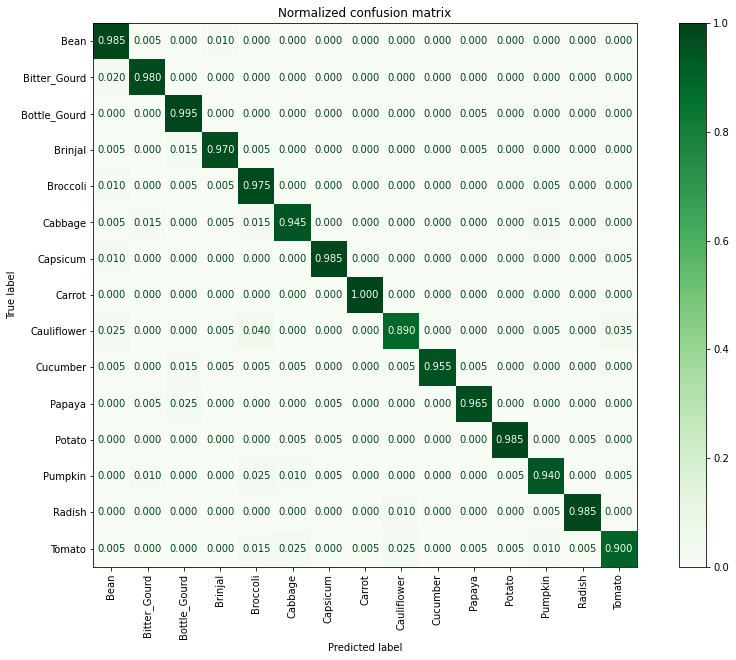

Accuracy: 0.9636666666666667


In [63]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

label_names = list(test_data.label_map.keys())

def plot_confusion_matrix(y_true, y_preds, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(15, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Greens", values_format=".3f", ax=ax)
    plt.title("Normalized confusion matrix")
    plt.xticks(rotation=90)
    plt.show()
    
plot_confusion_matrix(true_labels, predictions, label_names)
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy}')

In [64]:
print(classification_report(true_labels, predictions, digits=5, target_names = label_names))

              precision    recall  f1-score   support

        Bean    0.92056   0.98500   0.95169       200
Bitter_Gourd    0.96552   0.98000   0.97270       200
Bottle_Gourd    0.94313   0.99500   0.96837       200
     Brinjal    0.97000   0.97000   0.97000       200
    Broccoli    0.90278   0.97500   0.93750       200
     Cabbage    0.95455   0.94500   0.94975       200
    Capsicum    0.98500   0.98500   0.98500       200
      Carrot    0.99502   1.00000   0.99751       200
 Cauliflower    0.95699   0.89000   0.92228       200
    Cucumber    1.00000   0.95500   0.97698       200
      Papaya    0.97970   0.96500   0.97229       200
      Potato    0.98995   0.98500   0.98747       200
     Pumpkin    0.95918   0.94000   0.94949       200
      Radish    0.98995   0.98500   0.98747       200
      Tomato    0.95238   0.90000   0.92545       200

    accuracy                        0.96367      3000
   macro avg    0.96431   0.96367   0.96360      3000
weighted avg    0.96431   

# Testing on Custom Images

In [65]:
# test images
i1 = "/Users/andycherney/Pictures/20240529_222046.jpg" # Image of a cucumber
i2 = "/Users/andycherney/Pictures/20240529_212122.jpg" # Image of a container of tomatoes
my_images = (i1,i2)

torch.return_types.max(
values=tensor([-0.9078], grad_fn=<MaxBackward0>),
indices=tensor([9]))

Cucumber


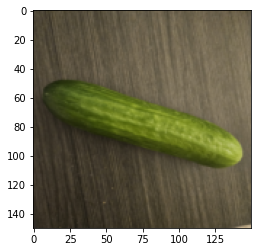

torch.return_types.max(
values=tensor([-4.7684e-07], grad_fn=<MaxBackward0>),
indices=tensor([14]))

Tomato


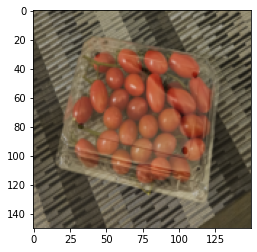

In [66]:
def predict(model,img_path, input_shape = target_size):
    model.eval()
    img = image_transform(os.path.join(img_path), *input_shape)
    y_pred = model(img.unsqueeze(dim=0))
    prediction = torch.max(y_pred, 1)
    print(prediction)
    print()
    print(label_names[prediction.indices.item()])
    plt.imshow(img.permute(1, 2, 0))
    plt.show()
    
for i in my_images:
    predict(best_CNN, i)